In [1]:
!pip install -U albumentations

     |████████████████████████████████| 102 kB 4.9 MB/s 
     |████████████████████████████████| 47.6 MB 36 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [2]:
%matplotlib inline

In [3]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR,OneCycleLR
import torch.optim as optim
from tqdm import tqdm


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import albumentations as A
from torch.utils.data import DataLoader, Dataset
from PIL import Image

In [5]:
import matplotlib.pyplot as plt
import numpy as np
!pip install torchsummary
from torchsummary import summary

### Augmentation

In [55]:
# EXPERIMENT horizontalflip_prob increased to 0.3 from 0.2, rotate_limit to 20 from 15
def data_albumentations(horizontalflip_prob = 0.2,
                        rotate_limit = 15,
                        shiftscalerotate_prob = 0.25,
                        num_holes = 1,
                        cutout_prob = 0.5):
    # Calculate mean and std deviation for cifar dataset
    mean,std = calculate_mean_std()
    
    # Train Phase transformations
    train_transforms = A.Compose([A.HorizontalFlip(p=horizontalflip_prob),
                                  A.GaussNoise(p=0.1),
                                  A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=rotate_limit, p=shiftscalerotate_prob),
                                  A.CoarseDropout(max_holes=num_holes,min_holes = 1, max_height=16, max_width=16, 
                                  p=cutout_prob,fill_value=tuple([x * 255.0 for x in mean]),
                                  min_height=16, min_width=16),
                                  A.ColorJitter(p=0.25,brightness=0.3, contrast=0.3, saturation=0.30, hue=0.2),
                                  A.ToGray(p=0.2),
                                  A.Normalize(mean=mean, std=std,always_apply=True),
                                  ToTensorV2()
                                ])

    # Test Phase transformations
    test_transforms = A.Compose([A.Normalize(mean=mean, std=std, always_apply=True),
                                 ToTensorV2()])

    return lambda img:train_transforms(image=np.array(img))["image"],lambda img:test_transforms(image=np.array(img))["image"]

### Helper functions

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [57]:
def plot_metrics(exp_metrics):
    sns.set(font_scale=1)
    plt.rcParams["figure.figsize"] = (25,6)
    train_accuracy,train_losses,test_accuracy,test_losses  = exp_metrics
    
    # Plot the learning curve.
    fig, (ax1,ax2) = plt.subplots(1,2)
    ax1.plot(np.array(test_losses), 'b', label="Validation Loss")
    
    # Label the plot.
    ax1.set_title("Validation Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    
    ax2.plot(np.array(test_accuracy), 'b', label="Validation Accuracy")
    
    # Label the plot.
    ax2.set_title("Validation Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend()
    
    plt.show()

In [58]:
def calculate_mean_std():
  train_transform = transforms.Compose([transforms.ToTensor()])
  train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
  mean = train_set.data.mean(axis=(0,1,2))/255
  std = train_set.data.std(axis=(0,1,2))/255
  return mean, std

In [59]:
def set_seed(seed,cuda_available):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda_available:
        torch.cuda.manual_seed(seed)

In [60]:
def model_summary(model, input_size=(3, 32, 32)):
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")
  print(model)
  summary(model,input_size)

In [61]:
def class_level_accuracy(model, test_loader, device, 
                         class_correct = list(0. for i in range(10)),
                         class_total = list(0. for i in range(10))):
  # specify the image classes
  classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
             'dog', 'frog', 'horse', 'ship', 'truck']
  with torch.no_grad():
    for data in test_loader:
      images, labels = data
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs, 1)
      c = (predicted == labels).squeeze()
      for i in range(4):
        label = labels[i]
        class_correct[label] += c[i].item()
        class_total[label] += 1
  for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

In [62]:
def wrong_predictions(test_loader,
                      use_cuda,
                      model):
        class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
        
        wrong_images=[]
        wrong_label=[]
        correct_label=[]
        with torch.no_grad():
            for data, target in test_loader:
                if use_cuda:
                  data = data.cuda()
                  target = target.cuda()

                output = model(data)        
                pred = output.argmax(dim=1, keepdim=True).squeeze()  # get the index of the max log-probability
                wrong_pred = (pred.eq(target.view_as(pred)) == False)
                wrong_images.append(data[wrong_pred])
                wrong_label.append(pred[wrong_pred])
                correct_label.append(target.view_as(pred)[wrong_pred])  
      
                wrong_predictions = list(zip(torch.cat(wrong_images),torch.cat(wrong_label),torch.cat(correct_label)))    
            print(f'Total wrong predictions are {len(wrong_predictions)}')
      
      
            fig = plt.figure(figsize=(18,20))
            fig.tight_layout()
            # mean,std = helper.calculate_mean_std("CIFAR10")
            for i, (img, pred, correct) in enumerate(wrong_predictions[:10]):
                  img, pred, target = img.cpu().numpy(), pred.cpu(), correct.cpu()
        
                  #mean = torch.FloatTensor(mean).view( 3, 1, 1).expand_as(img).cpu()
                  #std = torch.FloatTensor(std).view( 3, 1, 1).expand_as(img).cpu()
                  #img = img.mul(std).add(mean)
                  #img=img.numpy()
                  
                  img = np.transpose(img, (1, 2, 0)) / 2 + 0.5
                  ax = fig.add_subplot(5, 5, i+1)
                  ax.axis('off')
                  ax.set_title(f'\nactual : {class_names[target.item()]}\npredicted : {class_names[pred.item()]}',fontsize=10)  
                  ax.imshow(img)  
          
            plt.show()

In [63]:
def train(model, device, train_loader, optimizer, epoch,train_acc,train_loss,lambda_l1,scheduler,criterion,lrs,grad_clip=None):

  model.train()
  pbar = tqdm(train_loader)
  
  correct = 0
  processed = 0
  
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    
    #L1 Regularization
    if lambda_l1 > 0:
      l1 = 0
      for p in model.parameters():
        l1 = l1 + p.abs().sum()
      loss = loss + lambda_l1*l1

    train_loss.append(loss.data.cpu().numpy().item())

    # Backpropagation
    loss.backward()
    
    # Gradient clipping
    if grad_clip: 
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)
        
    optimizer.step()
    scheduler.step()
    lrs.append(get_lr(optimizer))

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} LR={lrs[-1]:0.5f} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

In [64]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [65]:
def visualize_sample_test_result(model,test_loader,use_cuda):
  # obtain one batch of test images
  dataiter = iter(test_loader)
  images, labels = dataiter.next()
  images.numpy()
  class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

  # move model inputs to cuda, if GPU available
  if use_cuda:
    images = images.cuda()

  # get sample outputs
  output = model(images)
  # convert output probabilities to predicted class
  _, preds_tensor = torch.max(output, 1)
  preds = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())
 # plot the images in the batch, along with predicted and true labels
  fig = plt.figure(figsize=(25, 4))
  for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx].cpu())
    ax.set_title("{} ({})".format(class_names[preds[idx]], class_names[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))   

## Data Loader

In [66]:
class Cifar10DataLoader:
    def __init__(self,batchsize=256):
      self.batch_size = batchsize
      self.num_workers = 2
      self.pin_memory = True

      train_transforms, test_transforms = data_albumentations()

      trainset = datasets.CIFAR10(root='./data', train=True,
                                  download=True, transform=train_transforms)
      
      testset  = datasets.CIFAR10(root='./data', train=False,
                                  download=True, transform=test_transforms)
      
      self.train_loader = torch.utils.data.DataLoader(trainset,
                                                      batch_size = self.batch_size,
                                                      shuffle = True,
                                                      num_workers = self.num_workers,
                                                      pin_memory = self.pin_memory)
      
      self.test_loader = torch.utils.data.DataLoader(testset, 
                                                      batch_size = self.batch_size,
                                                      shuffle = True,
                                                      num_workers = self.num_workers,
                                                      pin_memory = self.pin_memory)

## Training Functions

In [67]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [68]:
def train(model, device, train_loader, optimizer, epoch,train_acc,train_loss,lambda_l1,scheduler,criterion,lrs,grad_clip=None):

  model.train()
  pbar = tqdm(train_loader)
  
  correct = 0
  processed = 0
  
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    
    #L1 Regularization
    if lambda_l1 > 0:
      l1 = 0
      for p in model.parameters():
        l1 = l1 + p.abs().sum()
      loss = loss + lambda_l1*l1

    train_loss.append(loss.data.cpu().numpy().item())

    # Backpropagation
    loss.backward()
    
    # Gradient clipping
    if grad_clip: 
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)
        
    optimizer.step()
    scheduler.step()
    lrs.append(get_lr(optimizer))

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} LR={lrs[-1]:0.5f} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

In [69]:
def test(model, device, test_loader,test_acc,test_losses,criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [70]:
import torch.nn as nn
import torch.nn.functional as F


import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self,dropout):
        super(Net, self).__init__()
        
        ## Convolution Block1
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1, bias = False),  # Input: 32x32x3 | Output: 32x32x32 | RF: 3x3
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(dropout),

            nn.Conv2d(32, 64, 3, padding=1, bias = False), # Input: 32x32x32 | Output: 32x32x64 | RF: 5x5
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(dropout)
        )
        
        ## Transition Block1
        self.trans1 = nn.Sequential(
            nn.Conv2d(64, 32,1, stride=2), # Input: 32x32x64 | Output: 16x16x32 | RF: 5x5
            nn.ReLU(),
        )

        ## Convolution Block2
        self.conv2 =  nn.Sequential(
            nn.Conv2d(32, 32, 3,  padding=1, bias = False), # Input: 16x16x32 | Output: 16x16x32 | RF: 9x9
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(dropout),

            ## Depthwise Seperable Convolution1
            nn.Conv2d(32,32, 3,  padding=1,groups=32 ,bias = False),  # Input: 16x16x32 | Output: 16x16x32 | RF: 13x13
            nn.Conv2d(32, 64, 1, padding=1, bias = False),   # Input: 16x16x32 | Output: 18x18x64 | RF: 13x13
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(dropout),
        )
        
        #Transition Block2
        self.trans2 = nn.Sequential(

            nn.Conv2d(64, 32, 1, stride=2), # Input: 18x18x32 | Output: 9x9x64 | RF: 13x13
            nn.ReLU()
        )

        #Convolution Block3
        self.conv3 = nn.Sequential(
            
            ## Dilation Block
            nn.Conv2d(32, 64, 3,  padding=1, bias = False,dilation=2), # Input: 9x9x64 | Output: 7x7x64 | RF: 29x29
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(dropout),

            nn.Conv2d(64, 64, 3,  groups=64, padding=1, bias = False),  # Input: 7x7x64| Output: 7x7x64 | RF: 45x45
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(dropout),
        )

        #Transition Block3
        self.trans3 = nn.Sequential(

            nn.Conv2d(64, 16, 1, stride=2), # Input: 7x7x64| Output: 4x4x16 | RF: 61x61
            nn.ReLU()
        )

        #Convolution Block4        
        self.conv4 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1, bias = False), # Input: 4x4x16 | Output: 4x4x32 | RF: 93x93
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(dropout),

            ## Depthwise seperable Convolution2
            nn.Conv2d(32,32, 3,  padding=1,groups=32 ,bias = False),# Input: 4x4x16 | Output: 4x4x32 | RF: 125x125
            nn.Conv2d(32, 10, 1, padding=1, bias = False),          # Input: 4x4x32| Output: 6x6x10 | RF: 125x125
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout2d(dropout),
        )

        ## Output Block
        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(1)
        ) 


    def forward(self, x):
        y = x
        x = self.conv1(x)
        # x = torch.cat((y, x), dim=1)
        x = self.trans1(x)

       
        x = self.conv2(x)
        x = self.trans2(x) 

        x = self.conv3(x) 
        x = self.trans3(x)

        # y = x
        x = self.conv4(x)
        # x = torch.cat((y, x), dim=1) 
        x = self.gap(x)

        x = x.view(-1,10)
        return F.log_softmax(x,dim=1)

## Run Experiments

In [71]:
def run_experiments(device,
                    dataset,
                    epochs,
                    model):
  l1_factor = 0
  l2_factor = 0.0001
  # optim_type = optim.Adam
  criterion = nn.CrossEntropyLoss()
  # opt_func = optim.Adam
  lr = 0.01
  grad_clip = 0.1
  train_losses = []
  test_losses = []
  train_accuracy = []
  test_accuracy = []
  lrs=[]

  model = model
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2_factor)
  scheduler = OneCycleLR(optimizer, max_lr=lr,epochs=epochs,steps_per_epoch=len(dataset.train_loader))

  for epoch in range(1, epochs + 1):
    print(f'Epoch {epoch}:')
    train(model, device, dataset.train_loader, optimizer,epoch, train_accuracy, train_losses, l1_factor,scheduler,criterion,lrs,grad_clip)
    test(model, device, dataset.test_loader,test_accuracy,test_losses,criterion)
  
  return (train_accuracy,train_losses,test_accuracy,test_losses),model


In [72]:
def save_experiment(self,model, experiment_name='cifar10-adv'):
  print(f"Saving the model for {experiment_name}")
  torch.save(model, './saved_models/{}.pt'.format(experiment_name))

## Training

In [73]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [74]:
cifar_dataset=Cifar10DataLoader()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


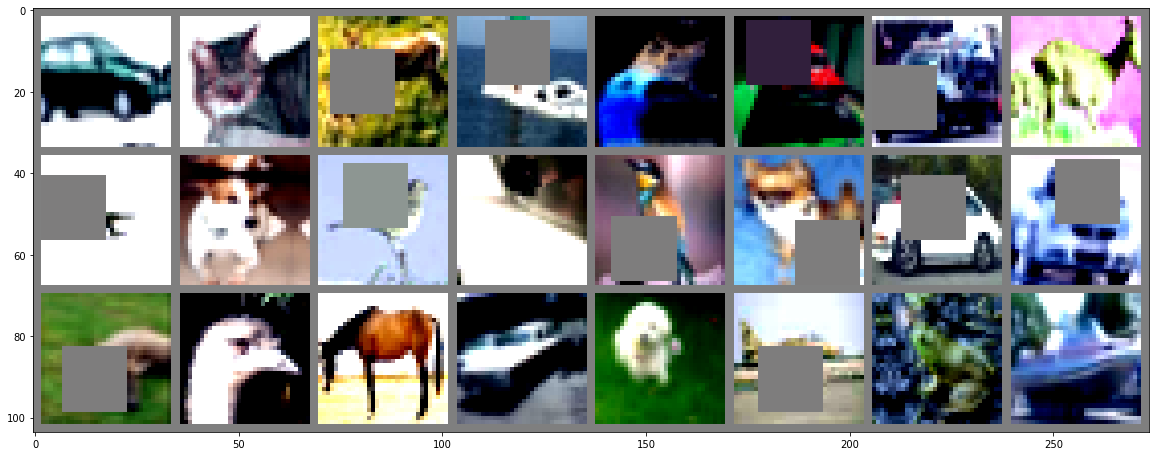

In [75]:
fig, ax = plt.subplots(figsize=(20, 20))
# get some random training images
dataiter = iter(cifar_dataset.train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:24]))

In [79]:
experiment_name = "cifar10-training"
epochs = 95
dropout = 0.01 ## increased from .01 - EXPERIMENT
model = Net(dropout).to(device)

In [80]:
model_summary(model)

Net(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.01, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout2d(p=0.01, inplace=False)
  )
  (trans1): Sequential(
    (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(2, 2))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.01, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (5): Conv2d(32, 64, kernel_size=(1, 1),

In [81]:
exp_metrics={}

exp_metrics[experiment_name],model = run_experiments(device,
                                                       cifar_dataset,
                                                       epochs,
                                                       model)

# save_experiment(model,experiment_name)

Epoch 1:


Loss=1.980994462966919 Batch_id=195 LR=0.00043 Accuracy=24.65: 100%|██████████| 196/196 [00:26<00:00,  7.46it/s]



Test set: Average loss: 0.0071, Accuracy: 3953/10000 (39.53%)

Epoch 2:


Loss=1.7331146001815796 Batch_id=195 LR=0.00052 Accuracy=37.27: 100%|██████████| 196/196 [00:25<00:00,  7.56it/s]



Test set: Average loss: 0.0062, Accuracy: 4797/10000 (47.97%)

Epoch 3:


Loss=1.5437984466552734 Batch_id=195 LR=0.00066 Accuracy=44.14: 100%|██████████| 196/196 [00:25<00:00,  7.57it/s]



Test set: Average loss: 0.0055, Accuracy: 5446/10000 (54.46%)

Epoch 4:


Loss=1.5937645435333252 Batch_id=195 LR=0.00086 Accuracy=49.22: 100%|██████████| 196/196 [00:26<00:00,  7.51it/s]



Test set: Average loss: 0.0051, Accuracy: 5825/10000 (58.25%)

Epoch 5:


Loss=1.351972222328186 Batch_id=195 LR=0.00111 Accuracy=53.45: 100%|██████████| 196/196 [00:25<00:00,  7.58it/s]



Test set: Average loss: 0.0046, Accuracy: 6166/10000 (61.66%)

Epoch 6:


Loss=1.2822247743606567 Batch_id=195 LR=0.00141 Accuracy=56.73: 100%|██████████| 196/196 [00:25<00:00,  7.55it/s]



Test set: Average loss: 0.0045, Accuracy: 6351/10000 (63.51%)

Epoch 7:


Loss=1.1308952569961548 Batch_id=195 LR=0.00176 Accuracy=59.06: 100%|██████████| 196/196 [00:26<00:00,  7.52it/s]



Test set: Average loss: 0.0041, Accuracy: 6596/10000 (65.96%)

Epoch 8:


Loss=1.1994441747665405 Batch_id=195 LR=0.00215 Accuracy=61.25: 100%|██████████| 196/196 [00:25<00:00,  7.59it/s]



Test set: Average loss: 0.0037, Accuracy: 6945/10000 (69.45%)

Epoch 9:


Loss=1.0575220584869385 Batch_id=195 LR=0.00258 Accuracy=62.17: 100%|██████████| 196/196 [00:26<00:00,  7.45it/s]



Test set: Average loss: 0.0035, Accuracy: 7072/10000 (70.72%)

Epoch 10:


Loss=1.2164413928985596 Batch_id=195 LR=0.00303 Accuracy=63.96: 100%|██████████| 196/196 [00:26<00:00,  7.47it/s]



Test set: Average loss: 0.0034, Accuracy: 7102/10000 (71.02%)

Epoch 11:


Loss=0.9942911267280579 Batch_id=195 LR=0.00352 Accuracy=64.69: 100%|██████████| 196/196 [00:26<00:00,  7.40it/s]



Test set: Average loss: 0.0034, Accuracy: 7168/10000 (71.68%)

Epoch 12:


Loss=1.081642746925354 Batch_id=195 LR=0.00402 Accuracy=65.50: 100%|██████████| 196/196 [00:26<00:00,  7.44it/s]



Test set: Average loss: 0.0033, Accuracy: 7296/10000 (72.96%)

Epoch 13:


Loss=1.1937202215194702 Batch_id=195 LR=0.00454 Accuracy=66.62: 100%|██████████| 196/196 [00:26<00:00,  7.49it/s]



Test set: Average loss: 0.0031, Accuracy: 7369/10000 (73.69%)

Epoch 14:


Loss=1.0989218950271606 Batch_id=195 LR=0.00507 Accuracy=67.11: 100%|██████████| 196/196 [00:26<00:00,  7.46it/s]



Test set: Average loss: 0.0029, Accuracy: 7419/10000 (74.19%)

Epoch 15:


Loss=1.0528144836425781 Batch_id=195 LR=0.00560 Accuracy=67.56: 100%|██████████| 196/196 [00:26<00:00,  7.48it/s]



Test set: Average loss: 0.0029, Accuracy: 7492/10000 (74.92%)

Epoch 16:


Loss=1.0623449087142944 Batch_id=195 LR=0.00612 Accuracy=67.78: 100%|██████████| 196/196 [00:26<00:00,  7.45it/s]



Test set: Average loss: 0.0032, Accuracy: 7240/10000 (72.40%)

Epoch 17:


Loss=0.9583193063735962 Batch_id=195 LR=0.00663 Accuracy=67.84: 100%|██████████| 196/196 [00:26<00:00,  7.52it/s]



Test set: Average loss: 0.0029, Accuracy: 7457/10000 (74.57%)

Epoch 18:


Loss=0.8552659749984741 Batch_id=195 LR=0.00713 Accuracy=68.70: 100%|██████████| 196/196 [00:26<00:00,  7.49it/s]



Test set: Average loss: 0.0028, Accuracy: 7655/10000 (76.55%)

Epoch 19:


Loss=1.0763152837753296 Batch_id=195 LR=0.00760 Accuracy=68.66: 100%|██████████| 196/196 [00:26<00:00,  7.53it/s]



Test set: Average loss: 0.0030, Accuracy: 7482/10000 (74.82%)

Epoch 20:


Loss=1.0727039575576782 Batch_id=195 LR=0.00804 Accuracy=69.06: 100%|██████████| 196/196 [00:25<00:00,  7.55it/s]



Test set: Average loss: 0.0028, Accuracy: 7610/10000 (76.10%)

Epoch 21:


Loss=0.8290998339653015 Batch_id=195 LR=0.00845 Accuracy=69.28: 100%|██████████| 196/196 [00:25<00:00,  7.56it/s]



Test set: Average loss: 0.0030, Accuracy: 7476/10000 (74.76%)

Epoch 22:


Loss=0.8762255907058716 Batch_id=195 LR=0.00882 Accuracy=69.75: 100%|██████████| 196/196 [00:26<00:00,  7.47it/s]



Test set: Average loss: 0.0028, Accuracy: 7609/10000 (76.09%)

Epoch 23:


Loss=1.0227752923965454 Batch_id=195 LR=0.00915 Accuracy=69.61: 100%|██████████| 196/196 [00:26<00:00,  7.49it/s]



Test set: Average loss: 0.0029, Accuracy: 7558/10000 (75.58%)

Epoch 24:


Loss=1.028892159461975 Batch_id=195 LR=0.00942 Accuracy=70.04: 100%|██████████| 196/196 [00:26<00:00,  7.48it/s]



Test set: Average loss: 0.0030, Accuracy: 7414/10000 (74.14%)

Epoch 25:


Loss=1.1268961429595947 Batch_id=195 LR=0.00965 Accuracy=70.30: 100%|██████████| 196/196 [00:26<00:00,  7.46it/s]



Test set: Average loss: 0.0032, Accuracy: 7361/10000 (73.61%)

Epoch 26:


Loss=0.8671852350234985 Batch_id=195 LR=0.00982 Accuracy=70.33: 100%|██████████| 196/196 [00:26<00:00,  7.37it/s]



Test set: Average loss: 0.0030, Accuracy: 7530/10000 (75.30%)

Epoch 27:


Loss=0.9958353042602539 Batch_id=195 LR=0.00993 Accuracy=70.29: 100%|██████████| 196/196 [00:26<00:00,  7.44it/s]



Test set: Average loss: 0.0030, Accuracy: 7531/10000 (75.31%)

Epoch 28:


Loss=0.9188106656074524 Batch_id=195 LR=0.00999 Accuracy=70.52: 100%|██████████| 196/196 [00:26<00:00,  7.50it/s]



Test set: Average loss: 0.0029, Accuracy: 7634/10000 (76.34%)

Epoch 29:


Loss=0.7192039489746094 Batch_id=195 LR=0.01000 Accuracy=70.67: 100%|██████████| 196/196 [00:25<00:00,  7.58it/s]



Test set: Average loss: 0.0032, Accuracy: 7340/10000 (73.40%)

Epoch 30:


Loss=0.7844175100326538 Batch_id=195 LR=0.00999 Accuracy=70.66: 100%|██████████| 196/196 [00:26<00:00,  7.44it/s]



Test set: Average loss: 0.0028, Accuracy: 7575/10000 (75.75%)

Epoch 31:


Loss=0.7397092580795288 Batch_id=195 LR=0.00997 Accuracy=70.85: 100%|██████████| 196/196 [00:26<00:00,  7.44it/s]



Test set: Average loss: 0.0026, Accuracy: 7808/10000 (78.08%)

Epoch 32:


Loss=0.893860936164856 Batch_id=195 LR=0.00993 Accuracy=70.81: 100%|██████████| 196/196 [00:26<00:00,  7.44it/s]



Test set: Average loss: 0.0028, Accuracy: 7582/10000 (75.82%)

Epoch 33:


Loss=0.8290572166442871 Batch_id=195 LR=0.00989 Accuracy=70.89: 100%|██████████| 196/196 [00:26<00:00,  7.48it/s]



Test set: Average loss: 0.0027, Accuracy: 7725/10000 (77.25%)

Epoch 34:


Loss=0.8299056887626648 Batch_id=195 LR=0.00983 Accuracy=71.32: 100%|██████████| 196/196 [00:25<00:00,  7.57it/s]



Test set: Average loss: 0.0030, Accuracy: 7454/10000 (74.54%)

Epoch 35:


Loss=0.7849246859550476 Batch_id=195 LR=0.00977 Accuracy=71.31: 100%|██████████| 196/196 [00:25<00:00,  7.62it/s]



Test set: Average loss: 0.0029, Accuracy: 7537/10000 (75.37%)

Epoch 36:


Loss=0.8834063410758972 Batch_id=195 LR=0.00969 Accuracy=71.29: 100%|██████████| 196/196 [00:26<00:00,  7.49it/s]



Test set: Average loss: 0.0026, Accuracy: 7729/10000 (77.29%)

Epoch 37:


Loss=0.8613823056221008 Batch_id=195 LR=0.00960 Accuracy=71.62: 100%|██████████| 196/196 [00:25<00:00,  7.58it/s]



Test set: Average loss: 0.0030, Accuracy: 7557/10000 (75.57%)

Epoch 38:


Loss=0.7181681394577026 Batch_id=195 LR=0.00950 Accuracy=71.47: 100%|██████████| 196/196 [00:25<00:00,  7.60it/s]



Test set: Average loss: 0.0028, Accuracy: 7638/10000 (76.38%)

Epoch 39:


Loss=0.6654278039932251 Batch_id=195 LR=0.00940 Accuracy=71.47: 100%|██████████| 196/196 [00:26<00:00,  7.51it/s]



Test set: Average loss: 0.0026, Accuracy: 7836/10000 (78.36%)

Epoch 40:


Loss=0.6573132872581482 Batch_id=195 LR=0.00928 Accuracy=71.99: 100%|██████████| 196/196 [00:26<00:00,  7.49it/s]



Test set: Average loss: 0.0025, Accuracy: 7849/10000 (78.49%)

Epoch 41:


Loss=0.9654024243354797 Batch_id=195 LR=0.00915 Accuracy=71.86: 100%|██████████| 196/196 [00:26<00:00,  7.45it/s]



Test set: Average loss: 0.0024, Accuracy: 7999/10000 (79.99%)

Epoch 42:


Loss=0.6988510489463806 Batch_id=195 LR=0.00902 Accuracy=71.88: 100%|██████████| 196/196 [00:26<00:00,  7.28it/s]



Test set: Average loss: 0.0025, Accuracy: 7825/10000 (78.25%)

Epoch 43:


Loss=0.8370404243469238 Batch_id=195 LR=0.00887 Accuracy=72.01: 100%|██████████| 196/196 [00:27<00:00,  7.23it/s]



Test set: Average loss: 0.0024, Accuracy: 8038/10000 (80.38%)

Epoch 44:


Loss=0.7292680144309998 Batch_id=195 LR=0.00872 Accuracy=72.01: 100%|██████████| 196/196 [00:26<00:00,  7.29it/s]



Test set: Average loss: 0.0024, Accuracy: 7939/10000 (79.39%)

Epoch 45:


Loss=0.9381158947944641 Batch_id=195 LR=0.00856 Accuracy=72.35: 100%|██████████| 196/196 [00:26<00:00,  7.37it/s]



Test set: Average loss: 0.0028, Accuracy: 7676/10000 (76.76%)

Epoch 46:


Loss=0.8554626703262329 Batch_id=195 LR=0.00839 Accuracy=72.64: 100%|██████████| 196/196 [00:26<00:00,  7.28it/s]



Test set: Average loss: 0.0026, Accuracy: 7814/10000 (78.14%)

Epoch 47:


Loss=0.871762752532959 Batch_id=195 LR=0.00821 Accuracy=72.61: 100%|██████████| 196/196 [00:26<00:00,  7.37it/s]



Test set: Average loss: 0.0026, Accuracy: 7851/10000 (78.51%)

Epoch 48:


Loss=0.9776899218559265 Batch_id=195 LR=0.00802 Accuracy=72.85: 100%|██████████| 196/196 [00:26<00:00,  7.39it/s]



Test set: Average loss: 0.0027, Accuracy: 7773/10000 (77.73%)

Epoch 49:


Loss=0.6120761036872864 Batch_id=195 LR=0.00783 Accuracy=73.18: 100%|██████████| 196/196 [00:26<00:00,  7.38it/s]



Test set: Average loss: 0.0025, Accuracy: 7910/10000 (79.10%)

Epoch 50:


Loss=0.9681493639945984 Batch_id=195 LR=0.00763 Accuracy=73.14: 100%|██████████| 196/196 [00:26<00:00,  7.32it/s]



Test set: Average loss: 0.0025, Accuracy: 7906/10000 (79.06%)

Epoch 51:


Loss=0.8868404626846313 Batch_id=195 LR=0.00743 Accuracy=73.10: 100%|██████████| 196/196 [00:26<00:00,  7.32it/s]



Test set: Average loss: 0.0023, Accuracy: 8061/10000 (80.61%)

Epoch 52:


Loss=0.7377335429191589 Batch_id=195 LR=0.00722 Accuracy=73.40: 100%|██████████| 196/196 [00:26<00:00,  7.30it/s]



Test set: Average loss: 0.0028, Accuracy: 7655/10000 (76.55%)

Epoch 53:


Loss=0.8739069700241089 Batch_id=195 LR=0.00701 Accuracy=73.35: 100%|██████████| 196/196 [00:26<00:00,  7.27it/s]



Test set: Average loss: 0.0025, Accuracy: 7841/10000 (78.41%)

Epoch 54:


Loss=0.7883079648017883 Batch_id=195 LR=0.00679 Accuracy=73.97: 100%|██████████| 196/196 [00:27<00:00,  7.25it/s]



Test set: Average loss: 0.0023, Accuracy: 8022/10000 (80.22%)

Epoch 55:


Loss=0.8692747354507446 Batch_id=195 LR=0.00657 Accuracy=73.99: 100%|██████████| 196/196 [00:26<00:00,  7.27it/s]



Test set: Average loss: 0.0023, Accuracy: 8014/10000 (80.14%)

Epoch 56:


Loss=0.5683602094650269 Batch_id=195 LR=0.00634 Accuracy=74.03: 100%|██████████| 196/196 [00:27<00:00,  7.19it/s]



Test set: Average loss: 0.0023, Accuracy: 8036/10000 (80.36%)

Epoch 57:


Loss=0.7826986908912659 Batch_id=195 LR=0.00611 Accuracy=74.63: 100%|██████████| 196/196 [00:26<00:00,  7.35it/s]



Test set: Average loss: 0.0026, Accuracy: 7856/10000 (78.56%)

Epoch 58:


Loss=0.7253021001815796 Batch_id=195 LR=0.00588 Accuracy=74.37: 100%|██████████| 196/196 [00:26<00:00,  7.41it/s]



Test set: Average loss: 0.0024, Accuracy: 8003/10000 (80.03%)

Epoch 59:


Loss=0.8514981269836426 Batch_id=195 LR=0.00565 Accuracy=74.80: 100%|██████████| 196/196 [00:26<00:00,  7.34it/s]



Test set: Average loss: 0.0022, Accuracy: 8206/10000 (82.06%)

Epoch 60:


Loss=0.5342346429824829 Batch_id=195 LR=0.00541 Accuracy=75.06: 100%|██████████| 196/196 [00:26<00:00,  7.26it/s]



Test set: Average loss: 0.0022, Accuracy: 8113/10000 (81.13%)

Epoch 61:


Loss=0.8383811712265015 Batch_id=195 LR=0.00518 Accuracy=75.26: 100%|██████████| 196/196 [00:26<00:00,  7.29it/s]



Test set: Average loss: 0.0021, Accuracy: 8200/10000 (82.00%)

Epoch 62:


Loss=0.7074201703071594 Batch_id=195 LR=0.00494 Accuracy=75.40: 100%|██████████| 196/196 [00:26<00:00,  7.29it/s]



Test set: Average loss: 0.0020, Accuracy: 8287/10000 (82.87%)

Epoch 63:


Loss=0.772400975227356 Batch_id=195 LR=0.00470 Accuracy=75.69: 100%|██████████| 196/196 [00:26<00:00,  7.28it/s]



Test set: Average loss: 0.0020, Accuracy: 8263/10000 (82.63%)

Epoch 64:


Loss=0.6431008577346802 Batch_id=195 LR=0.00447 Accuracy=75.90: 100%|██████████| 196/196 [00:27<00:00,  7.22it/s]



Test set: Average loss: 0.0021, Accuracy: 8229/10000 (82.29%)

Epoch 65:


Loss=0.6858214139938354 Batch_id=195 LR=0.00423 Accuracy=76.00: 100%|██████████| 196/196 [00:26<00:00,  7.26it/s]



Test set: Average loss: 0.0020, Accuracy: 8295/10000 (82.95%)

Epoch 66:


Loss=0.6390305757522583 Batch_id=195 LR=0.00400 Accuracy=76.25: 100%|██████████| 196/196 [00:26<00:00,  7.29it/s]



Test set: Average loss: 0.0021, Accuracy: 8240/10000 (82.40%)

Epoch 67:


Loss=0.5647112727165222 Batch_id=195 LR=0.00377 Accuracy=76.49: 100%|██████████| 196/196 [00:26<00:00,  7.31it/s]



Test set: Average loss: 0.0021, Accuracy: 8252/10000 (82.52%)

Epoch 68:


Loss=0.7965987920761108 Batch_id=195 LR=0.00354 Accuracy=76.86: 100%|██████████| 196/196 [00:26<00:00,  7.37it/s]



Test set: Average loss: 0.0020, Accuracy: 8378/10000 (83.78%)

Epoch 69:


Loss=0.5937212705612183 Batch_id=195 LR=0.00332 Accuracy=77.27: 100%|██████████| 196/196 [00:26<00:00,  7.30it/s]



Test set: Average loss: 0.0019, Accuracy: 8402/10000 (84.02%)

Epoch 70:


Loss=0.7469456791877747 Batch_id=195 LR=0.00310 Accuracy=77.47: 100%|██████████| 196/196 [00:26<00:00,  7.30it/s]



Test set: Average loss: 0.0019, Accuracy: 8380/10000 (83.80%)

Epoch 71:


Loss=0.6734296083450317 Batch_id=195 LR=0.00288 Accuracy=77.51: 100%|██████████| 196/196 [00:26<00:00,  7.28it/s]



Test set: Average loss: 0.0018, Accuracy: 8423/10000 (84.23%)

Epoch 72:


Loss=0.864229679107666 Batch_id=195 LR=0.00267 Accuracy=77.99: 100%|██████████| 196/196 [00:26<00:00,  7.31it/s]



Test set: Average loss: 0.0018, Accuracy: 8438/10000 (84.38%)

Epoch 73:


Loss=0.5459539890289307 Batch_id=195 LR=0.00246 Accuracy=78.20: 100%|██████████| 196/196 [00:26<00:00,  7.33it/s]



Test set: Average loss: 0.0018, Accuracy: 8465/10000 (84.65%)

Epoch 74:


Loss=0.6876190900802612 Batch_id=195 LR=0.00226 Accuracy=78.37: 100%|██████████| 196/196 [00:26<00:00,  7.32it/s]



Test set: Average loss: 0.0018, Accuracy: 8479/10000 (84.79%)

Epoch 75:


Loss=0.6171644330024719 Batch_id=195 LR=0.00207 Accuracy=78.32: 100%|██████████| 196/196 [00:26<00:00,  7.29it/s]



Test set: Average loss: 0.0017, Accuracy: 8539/10000 (85.39%)

Epoch 76:


Loss=0.9139512777328491 Batch_id=195 LR=0.00188 Accuracy=79.13: 100%|██████████| 196/196 [00:27<00:00,  7.21it/s]



Test set: Average loss: 0.0017, Accuracy: 8544/10000 (85.44%)

Epoch 77:


Loss=0.7198222875595093 Batch_id=195 LR=0.00170 Accuracy=78.78: 100%|██████████| 196/196 [00:26<00:00,  7.34it/s]



Test set: Average loss: 0.0017, Accuracy: 8556/10000 (85.56%)

Epoch 78:


Loss=0.49838295578956604 Batch_id=195 LR=0.00153 Accuracy=79.40: 100%|██████████| 196/196 [00:26<00:00,  7.36it/s]



Test set: Average loss: 0.0017, Accuracy: 8572/10000 (85.72%)

Epoch 79:


Loss=0.49850088357925415 Batch_id=195 LR=0.00136 Accuracy=79.50: 100%|██████████| 196/196 [00:27<00:00,  7.24it/s]



Test set: Average loss: 0.0017, Accuracy: 8562/10000 (85.62%)

Epoch 80:


Loss=0.5960886478424072 Batch_id=195 LR=0.00120 Accuracy=80.06: 100%|██████████| 196/196 [00:27<00:00,  7.19it/s]



Test set: Average loss: 0.0016, Accuracy: 8576/10000 (85.76%)

Epoch 81:


Loss=0.4998508095741272 Batch_id=195 LR=0.00105 Accuracy=79.94: 100%|██████████| 196/196 [00:27<00:00,  7.25it/s]



Test set: Average loss: 0.0016, Accuracy: 8597/10000 (85.97%)

Epoch 82:


Loss=0.5545825362205505 Batch_id=195 LR=0.00091 Accuracy=80.27: 100%|██████████| 196/196 [00:27<00:00,  7.25it/s]



Test set: Average loss: 0.0016, Accuracy: 8636/10000 (86.36%)

Epoch 83:


Loss=0.39911890029907227 Batch_id=195 LR=0.00078 Accuracy=80.55: 100%|██████████| 196/196 [00:26<00:00,  7.26it/s]



Test set: Average loss: 0.0016, Accuracy: 8626/10000 (86.26%)

Epoch 84:


Loss=0.5222940444946289 Batch_id=195 LR=0.00066 Accuracy=80.44: 100%|██████████| 196/196 [00:27<00:00,  7.16it/s]



Test set: Average loss: 0.0016, Accuracy: 8636/10000 (86.36%)

Epoch 85:


Loss=0.6492816209793091 Batch_id=195 LR=0.00055 Accuracy=81.00: 100%|██████████| 196/196 [00:26<00:00,  7.28it/s]



Test set: Average loss: 0.0016, Accuracy: 8651/10000 (86.51%)

Epoch 86:


Loss=0.7073841094970703 Batch_id=195 LR=0.00044 Accuracy=80.93: 100%|██████████| 196/196 [00:26<00:00,  7.27it/s]



Test set: Average loss: 0.0016, Accuracy: 8663/10000 (86.63%)

Epoch 87:


Loss=0.5450696349143982 Batch_id=195 LR=0.00035 Accuracy=81.23: 100%|██████████| 196/196 [00:27<00:00,  7.22it/s]



Test set: Average loss: 0.0016, Accuracy: 8666/10000 (86.66%)

Epoch 88:


Loss=0.7058929204940796 Batch_id=195 LR=0.00027 Accuracy=81.07: 100%|██████████| 196/196 [00:27<00:00,  7.20it/s]



Test set: Average loss: 0.0016, Accuracy: 8696/10000 (86.96%)

Epoch 89:


Loss=0.6802202463150024 Batch_id=195 LR=0.00020 Accuracy=81.51: 100%|██████████| 196/196 [00:27<00:00,  7.20it/s]



Test set: Average loss: 0.0015, Accuracy: 8690/10000 (86.90%)

Epoch 90:


Loss=0.8162833452224731 Batch_id=195 LR=0.00014 Accuracy=81.57: 100%|██████████| 196/196 [00:26<00:00,  7.33it/s]



Test set: Average loss: 0.0016, Accuracy: 8709/10000 (87.09%)

Epoch 91:


Loss=0.8466346859931946 Batch_id=195 LR=0.00009 Accuracy=81.55: 100%|██████████| 196/196 [00:27<00:00,  7.24it/s]



Test set: Average loss: 0.0015, Accuracy: 8696/10000 (86.96%)

Epoch 92:


Loss=0.4242306351661682 Batch_id=195 LR=0.00005 Accuracy=81.50: 100%|██████████| 196/196 [00:26<00:00,  7.26it/s]



Test set: Average loss: 0.0015, Accuracy: 8706/10000 (87.06%)

Epoch 93:


Loss=0.44330358505249023 Batch_id=195 LR=0.00002 Accuracy=81.61: 100%|██████████| 196/196 [00:27<00:00,  7.25it/s]



Test set: Average loss: 0.0016, Accuracy: 8700/10000 (87.00%)

Epoch 94:


Loss=0.49114927649497986 Batch_id=195 LR=0.00001 Accuracy=81.72: 100%|██████████| 196/196 [00:26<00:00,  7.32it/s]



Test set: Average loss: 0.0015, Accuracy: 8702/10000 (87.02%)

Epoch 95:


Loss=0.4428507387638092 Batch_id=195 LR=0.00000 Accuracy=81.49: 100%|██████████| 196/196 [00:27<00:00,  7.25it/s]



Test set: Average loss: 0.0015, Accuracy: 8708/10000 (87.08%)



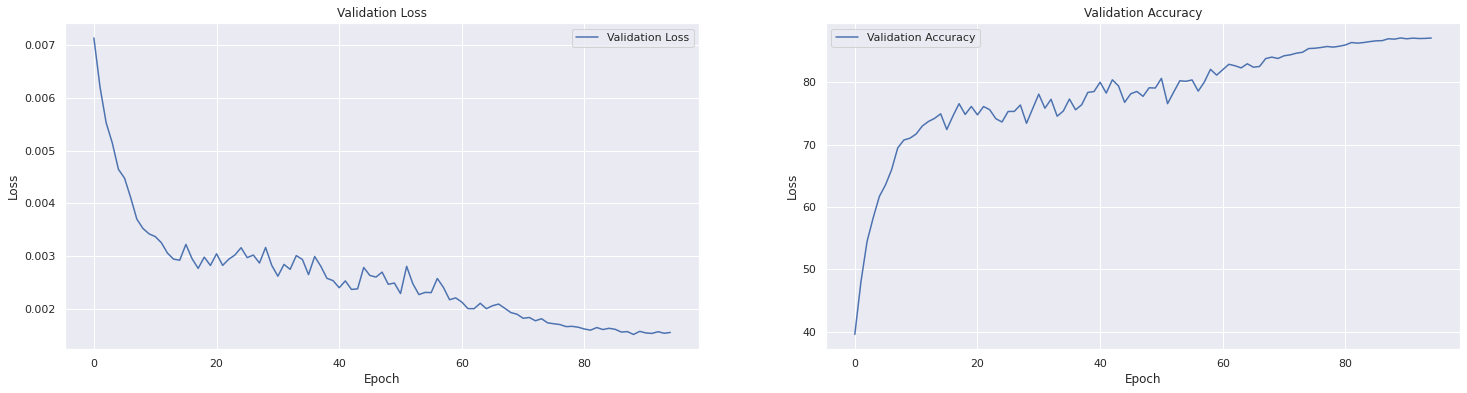

In [82]:
plot_metrics(exp_metrics[experiment_name])     

In [83]:
# experiment_name = "cifar10-training-finetune"
# epochs = 20
# dropout = 0.01 ## increased from .01 - EXPERIMENT
# model = Net(dropout).to(device)

# exp_metrics={}

# exp_metrics[experiment_name],model = run_experiments(device,
#                                                        cifar_dataset,
#                                                        epochs,
#                                                        model)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total wrong predictions are 1292


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


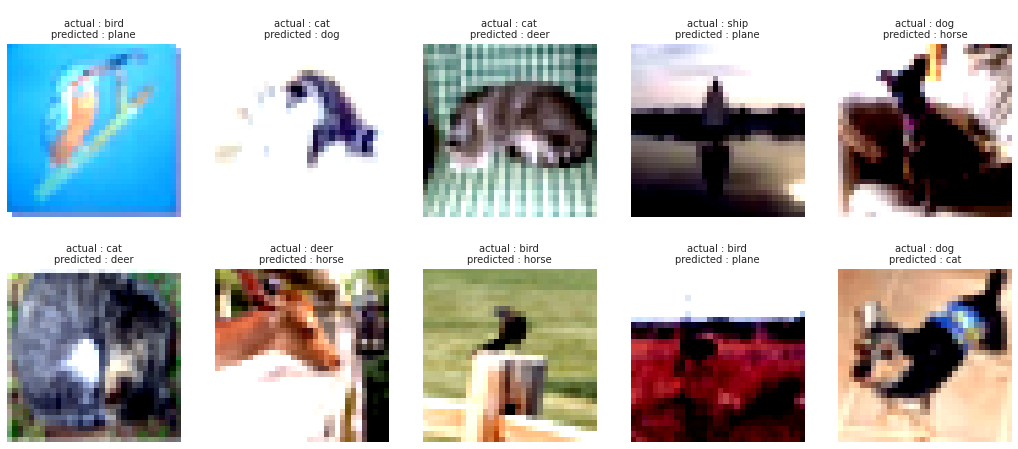

In [84]:
# model = torch.load(f'./saved_models/{experiment_name}.pt')
model.eval()
wrong_predictions(cifar_dataset.test_loader,
                  use_cuda,
                  model)

In [85]:
class_level_accuracy(model, cifar_dataset.test_loader, device)

Accuracy of airplane : 100 %
Accuracy of automobile : 100 %
Accuracy of  bird : 75 %
Accuracy of   cat : 71 %
Accuracy of  deer : 78 %
Accuracy of   dog : 68 %
Accuracy of  frog : 92 %
Accuracy of horse : 88 %
Accuracy of  ship : 96 %
Accuracy of truck : 100 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

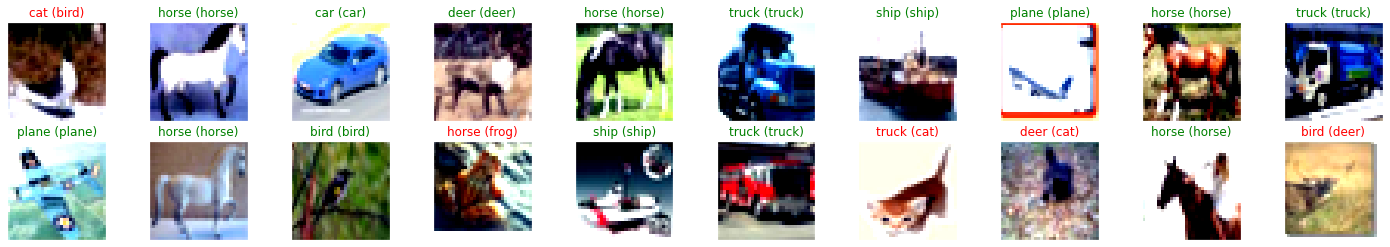

In [86]:
visualize_sample_test_result(model, 
                             cifar_dataset.test_loader,
                             use_cuda)

In [87]:
!pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=1182a0592191e90711f7c85f761ee649f23b40af0837e26121fe2c457484f666
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [88]:
model = model.to(device)

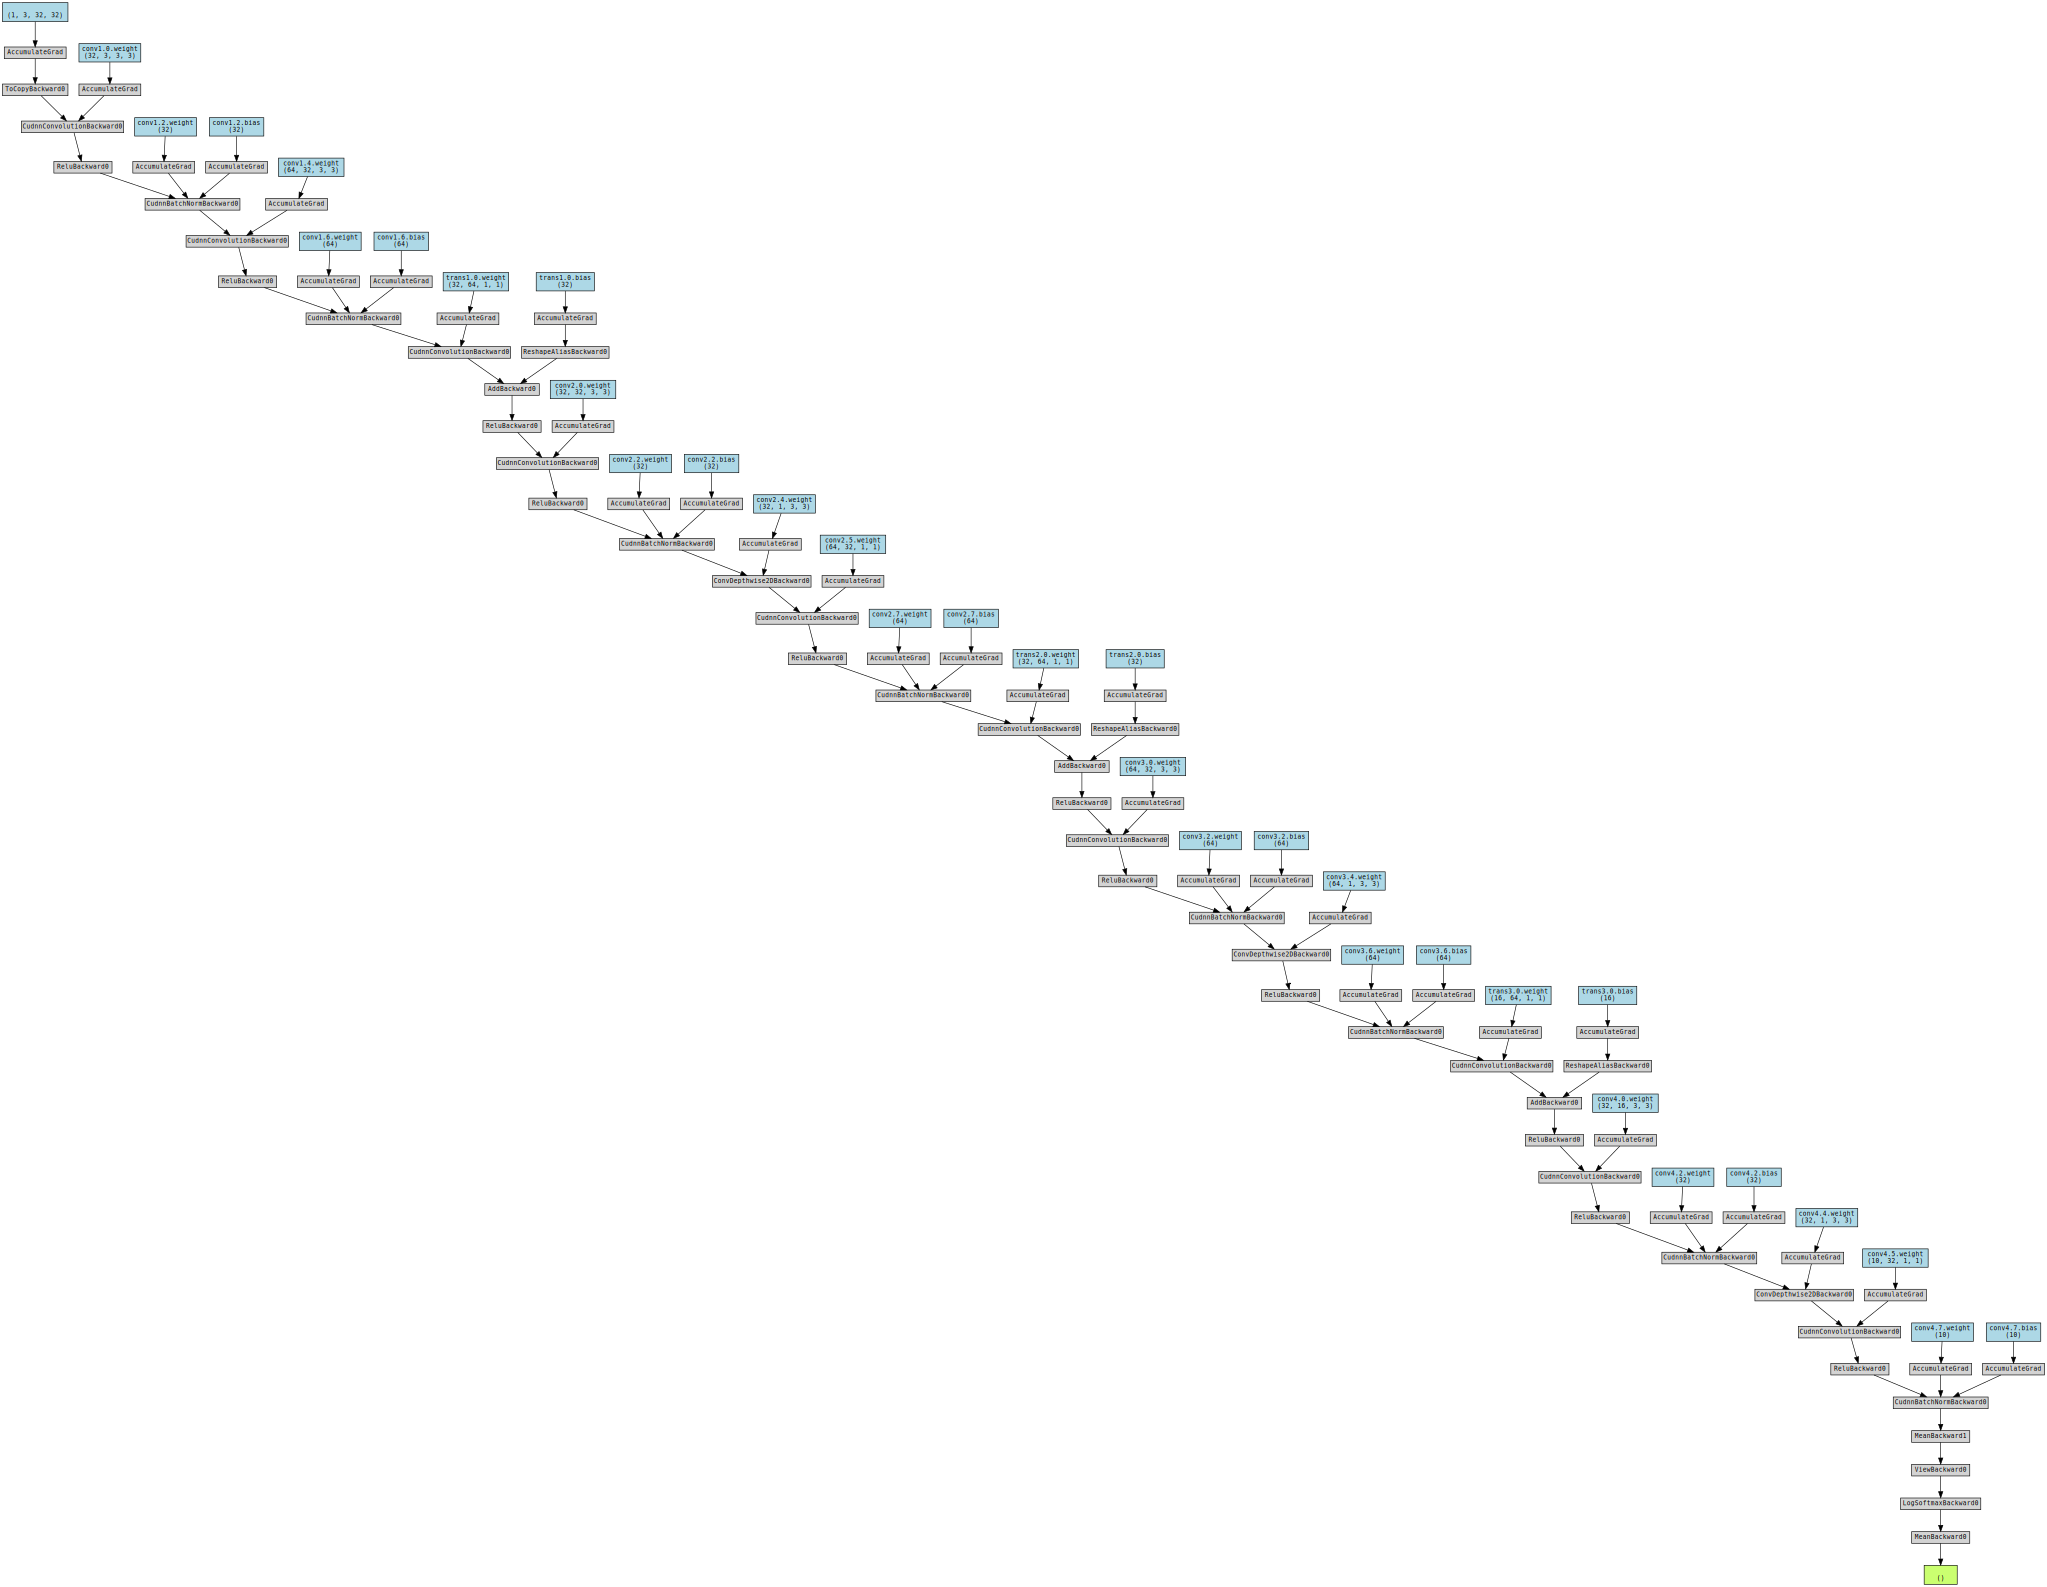

In [89]:
 from torchviz import make_dot
 x = torch.randn(1, 3, 32, 32).requires_grad_(True).cuda()
 y = model(x)   
 MyConvNetVis = make_dot(y, params=dict(list(model.named_parameters()) + [('x', x)]))
 MyConvNetVis.format = "png"
 MyConvNetVis.directory = "data"
 MyConvNetVis.view()
 make_dot(y.mean(), params=dict(model.named_parameters()))


In [90]:
model.train()
experiment_name = "cifar10-training-finetune"
epochs = 20
dropout = 0.01 ## increased from .01 - EXPERIMENT
model = Net(dropout).to(device)

exp_metrics={}

exp_metrics[experiment_name],model = run_experiments(device,
                                                       cifar_dataset,
                                                       epochs,
                                                       model)


Epoch 1:


Loss=1.9587452411651611 Batch_id=195 LR=0.00104 Accuracy=25.66: 100%|██████████| 196/196 [00:26<00:00,  7.44it/s]



Test set: Average loss: 0.0070, Accuracy: 4011/10000 (40.11%)

Epoch 2:


Loss=1.586071252822876 Batch_id=195 LR=0.00280 Accuracy=41.70: 100%|██████████| 196/196 [00:26<00:00,  7.46it/s]



Test set: Average loss: 0.0060, Accuracy: 4869/10000 (48.69%)

Epoch 3:


Loss=1.35132896900177 Batch_id=195 LR=0.00521 Accuracy=49.57: 100%|██████████| 196/196 [00:26<00:00,  7.47it/s]



Test set: Average loss: 0.0052, Accuracy: 5477/10000 (54.77%)

Epoch 4:


Loss=1.361823320388794 Batch_id=195 LR=0.00761 Accuracy=53.89: 100%|██████████| 196/196 [00:26<00:00,  7.30it/s]



Test set: Average loss: 0.0043, Accuracy: 6181/10000 (61.81%)

Epoch 5:


Loss=1.250556468963623 Batch_id=195 LR=0.00936 Accuracy=57.67: 100%|██████████| 196/196 [00:26<00:00,  7.31it/s]



Test set: Average loss: 0.0044, Accuracy: 6216/10000 (62.16%)

Epoch 6:


Loss=1.0568547248840332 Batch_id=195 LR=0.01000 Accuracy=60.87: 100%|██████████| 196/196 [00:26<00:00,  7.43it/s]



Test set: Average loss: 0.0041, Accuracy: 6475/10000 (64.75%)

Epoch 7:


Loss=1.0389833450317383 Batch_id=195 LR=0.00987 Accuracy=62.79: 100%|██████████| 196/196 [00:26<00:00,  7.28it/s]



Test set: Average loss: 0.0038, Accuracy: 6754/10000 (67.54%)

Epoch 8:


Loss=0.9567022323608398 Batch_id=195 LR=0.00950 Accuracy=64.91: 100%|██████████| 196/196 [00:26<00:00,  7.33it/s]



Test set: Average loss: 0.0034, Accuracy: 7003/10000 (70.03%)

Epoch 9:


Loss=0.799088180065155 Batch_id=195 LR=0.00891 Accuracy=65.99: 100%|██████████| 196/196 [00:26<00:00,  7.48it/s]



Test set: Average loss: 0.0032, Accuracy: 7274/10000 (72.74%)

Epoch 10:


Loss=1.1382838487625122 Batch_id=195 LR=0.00811 Accuracy=66.95: 100%|██████████| 196/196 [00:26<00:00,  7.33it/s]



Test set: Average loss: 0.0032, Accuracy: 7145/10000 (71.45%)

Epoch 11:


Loss=1.059501051902771 Batch_id=195 LR=0.00716 Accuracy=67.68: 100%|██████████| 196/196 [00:26<00:00,  7.39it/s]



Test set: Average loss: 0.0032, Accuracy: 7259/10000 (72.59%)

Epoch 12:


Loss=0.6315642595291138 Batch_id=195 LR=0.00611 Accuracy=68.71: 100%|██████████| 196/196 [00:26<00:00,  7.33it/s]



Test set: Average loss: 0.0026, Accuracy: 7770/10000 (77.70%)

Epoch 13:


Loss=0.9321548342704773 Batch_id=195 LR=0.00499 Accuracy=69.89: 100%|██████████| 196/196 [00:26<00:00,  7.33it/s]



Test set: Average loss: 0.0026, Accuracy: 7764/10000 (77.64%)

Epoch 14:


Loss=0.8862100839614868 Batch_id=195 LR=0.00388 Accuracy=70.49: 100%|██████████| 196/196 [00:26<00:00,  7.30it/s]



Test set: Average loss: 0.0024, Accuracy: 7888/10000 (78.88%)

Epoch 15:


Loss=0.8879618644714355 Batch_id=195 LR=0.00283 Accuracy=71.74: 100%|██████████| 196/196 [00:26<00:00,  7.32it/s]



Test set: Average loss: 0.0024, Accuracy: 7985/10000 (79.85%)

Epoch 16:


Loss=0.8451985120773315 Batch_id=195 LR=0.00188 Accuracy=73.08: 100%|██████████| 196/196 [00:26<00:00,  7.38it/s]



Test set: Average loss: 0.0023, Accuracy: 8010/10000 (80.10%)

Epoch 17:


Loss=0.8793913722038269 Batch_id=195 LR=0.00109 Accuracy=73.72: 100%|██████████| 196/196 [00:26<00:00,  7.36it/s]



Test set: Average loss: 0.0022, Accuracy: 8146/10000 (81.46%)

Epoch 18:


Loss=0.7493293285369873 Batch_id=195 LR=0.00049 Accuracy=74.51: 100%|██████████| 196/196 [00:26<00:00,  7.30it/s]



Test set: Average loss: 0.0021, Accuracy: 8178/10000 (81.78%)

Epoch 19:


Loss=0.7688835263252258 Batch_id=195 LR=0.00012 Accuracy=75.07: 100%|██████████| 196/196 [00:26<00:00,  7.35it/s]



Test set: Average loss: 0.0021, Accuracy: 8221/10000 (82.21%)

Epoch 20:


Loss=0.8362969160079956 Batch_id=195 LR=0.00000 Accuracy=75.21: 100%|██████████| 196/196 [00:26<00:00,  7.35it/s]



Test set: Average loss: 0.0021, Accuracy: 8210/10000 (82.10%)



In [91]:
class_level_accuracy(model, cifar_dataset.test_loader, device)

Accuracy of airplane : 88 %
Accuracy of automobile : 96 %
Accuracy of  bird : 75 %
Accuracy of   cat : 55 %
Accuracy of  deer : 78 %
Accuracy of   dog : 68 %
Accuracy of  frog : 89 %
Accuracy of horse : 92 %
Accuracy of  ship : 95 %
Accuracy of truck : 100 %
